In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
from torch.utils.data import random_split
import models.optimizer.optimizer as optimizer

# todo: select model here, uncomment to select the model
# from models.old import Alex_256_relu as m
# from models import Alex_256_sigmoid as m
from models.old_models import Alex_256_tanh as m
# from models import Alex_4096_relu as m
# from models import Alex_4096_tanh as m

from helper.training_early_stop import EarlyStop
import helper.utility as utility
import os

# 0. Data Pre-processing

In [2]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # turn the graph to single color channel
    transforms.Resize((227, 227)), # resize to 227 * 227 because we use AlexNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # normalize
])

train_dataset = datasets.ImageFolder(
    '../dataset/train', transform=data_transforms)
# split training set to training set and validation set
# a random seed to ensure reproducibility of results.
torch.manual_seed(42)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.ImageFolder('../dataset/test', transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128,shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=16, pin_memory=False)

print(len(val_loader), len(train_dataset))

23 25838


/usr/local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [3]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using mac mps


# 1. Model

In [4]:
# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [5]:
# todo: select optimizer
optimizer_name = "Adam"  # or "SGD"
# optimizer_name = "SGD"

# saving path
m.model_name += m.model_name + optimizer_name
m.pth_save_path = './model_data/' + m.model_name + '/model.pth'
m.pth_manual_save_path = './model_data/' + \
    m.model_name + '/manual_save_model.pth'
m.record_save_path = './model_data/' + m.model_name

# initialize model, loss-function and optimizer
model = m.EmotionCNN(num_classes=7)  # FER-2013 has 7 emotion class
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = optimizer.create_optimizer(
    model.parameters(), optimizer_name)

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/dlib-19.24.99-py3.11-macosx-13-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


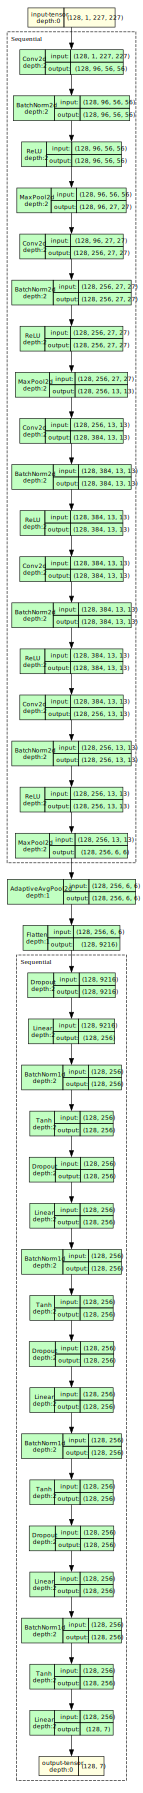

In [20]:
import torchvision
!pip3 install torchview
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(128,1,227,227), expand_nested=True)
model_graph.visual_graph

In [ ]:
# training model
num_epochs = 2000

# early stopping variables
stop_counter = 10 # number of count to trigger early stop
stop_counter_window = 15 # a range to check stop_counter
different = 0.0001 # different between the best val loss and the most recent one
stop_counter_interval = 30 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after =0
early_stopping = EarlyStop(m.pth_save_path, stop_counter, different, type="accuracy")

In [ ]:
model.to(device)

# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forwarding get output
        outputs = model(inputs)
        # compute loss of output
        loss = criterion(outputs, labels)
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record training status
        running_loss += loss.item()
        prediction = outputs.argmax(dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        correct_prediction_pre_epoch.append(num_correct_prediction)
        accuracy += num_correct_prediction / inputs.shape[0]
    # save training status
    loss_history_per_epoch.append((running_loss / len(train_loader)))
    accuracy_per_epoch.append((accuracy / len(train_loader)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch% stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                prediction = outputs.argmax(dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy
        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        early_stopping.check_status(model, val_accuracy)

        # display recently 5 average loss of epochs
        process.set_description(f"avg loss[-5:] = {['{:.5f}'.format(num) for num in loss_history_per_epoch[-5:]]}\t"
                                f"val loss[-5:] = {['{:.5f}'.format(num) for num in val_loss_per_epoch[-5:]]}\t"
                                f"accuracy[-5:] = {['{:.3%}'.format(num) for num in accuracy_per_epoch[-5:]]}\t"
                                f"val accuracy[-5:] = {['{:.3%}'.format(num) for num in val_accuracy_per_epoch[-5:]]}\t"
                                f"best value = {'{:.3%}'.format(early_stopping.best_of_all_value)}\t"
                                f"Counter = {early_stopping.counter}/{stop_counter} | {counter}/{stop_counter_window}\t")
    else:
        process.set_description(f"avg loss[-5:] = {['{:.5f}'.format(num) for num in loss_history_per_epoch[-5:]]}\t"
                                f"accuracy[-5:] = {['{:.3%}'.format(num) for num in accuracy_per_epoch[-5:]]}\t")

    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        early_stopping.early_stop = False
        break

# 2. Save model and records

In [ ]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

# 3. Plot records and Evaluation

In [ ]:
# draw graphs
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(1, len(data)+1), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy",
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation loss",
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(
    m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(run_after+1, run_after+len(data)+1), y=data, xlabel="epoch", ylabel="validation accuracy",
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")


In [ ]:
# evaluate model
model = m.EmotionCNN(num_classes=7)
utility.model_validation(model, device, test_loader, m.pth_save_path, m.record_save_path)
utility.model_validation(model, device, test_loader, m.pth_manual_save_path, m.record_save_path)